In [7]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# set seed
torch.manual_seed(42)
np.random.seed(42)


In [8]:
from typing import Tuple, List, Callable
from torch.distributions import Distribution
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.stats import gaussian_kde
from IPython.display import clear_output


In [9]:
# run with CUDA if available
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available and being used")
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU instead")

GPU is available and being used


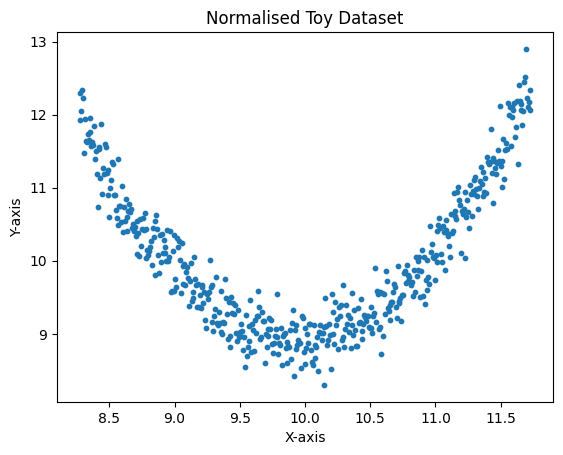

In [4]:
# Generate synthetic 2D data like one moon
#   This will simulate the z values in the latent distribution of Posterior Network
#   We wish to learn the density for one class of data P(z |c, phi), where phi is the parameters of the distribution
n_samples = 500
a = +0.5
b = +0.2
c = -4
x = np.linspace(-5, 5, n_samples)
y = a * x**2 + b * x + c
noise_scale = 1.0
y_noisy = y + noise_scale * np.random.randn(len(x))
data = np.vstack((x, y_noisy)).T
# Plot the toy dataset
# plt.scatter(data[:, 0], data[:, 1], s=10)
# plt.title("Toy Dataset with Negative 2nd-Degree Polynomial")
# plt.xlabel("X-axis")
# plt.ylabel("Y-axis")
# plt.show()

# Preprocess the data (standardize)
scaler = StandardScaler()
data = scaler.fit_transform(data)
# Convert data to PyTorch tensor
X_tensor = torch.FloatTensor(data)
X_tensor = X_tensor+10

#plot the X_tensor next to the original data
plt.scatter(X_tensor[:, 0], X_tensor[:, 1], s=10)
plt.title("Normalised Toy Dataset")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()

In [10]:
# https://sebastiancallh.github.io/post/affine-normalizing-flows/

# uses Real NVP paper

# Define the Normalizing Flow model template
class NormalizingFlow(nn.Module):

    def __init__(self, latent: Distribution, flows: List[nn.Module]):
        super(NormalizingFlow, self).__init__()
        self.latent = latent
        self.flows = nn.ModuleList(flows)

    def latent_log_prob(self, z: torch.Tensor) -> torch.Tensor:
        return self.latent.log_prob(z)

    def latent_sample(self, num_samples: int = 1) -> torch.Tensor:
        return self.latent.sample((num_samples,))

    def sample(self, num_samples: int = 1) -> torch.Tensor:
        '''Sample a new observation x by sampling z from
        the latent distribution and pass through g.'''
        return self.g(self.latent_sample(num_samples))

    def f(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        '''Maps observation x to latent variable z.
        Additionally, computes the log determinant
        of the Jacobian for this transformation.
        Inverse of g.'''
        z, sum_log_abs_det = x, torch.zeros(x.size(0)).to(device) #zeros?
        
        # takes the number of samples and returns a tensor of ones with the same size
        for flow in self.flows:
            z, log_abs_det = flow.f(z)
            sum_log_abs_det += log_abs_det

        return z, sum_log_abs_det

    def g(self, z: torch.Tensor) -> torch.Tensor:
        '''Maps latent variable z to observation x.
        Inverse of f.'''
        with torch.no_grad():
            x = z
            for flow in reversed(self.flows):
                x = flow.g(x)

        return x

    def g_steps(self, z: torch.Tensor) -> List[torch.Tensor]:
        '''Maps latent variable z to observation x
        and stores intermediate results.'''
        xs = [z]
        for flow in reversed(self.flows):
            xs.append(flow.g(xs[-1]))

        return xs

    def log_prob(self, x: torch.Tensor) -> torch.Tensor:
        '''Computes log p(x) using the change of variable formula.'''
        z, log_abs_det = self.f(x)
        return self.latent_log_prob(z) + log_abs_det

    def __len__(self) -> int:
        return len(self.flows)


class AffineCouplingLayer(nn.Module):

    def __init__(self, theta: nn.Module, split: Callable[[torch.Tensor], Tuple[torch.Tensor, torch.Tensor]]):
        super(AffineCouplingLayer, self).__init__()
        self.theta = theta
        self.split = split

    def f(self, x: torch.Tensor) -> torch.Tensor:
        '''f: x -> z. The inverse of g.'''
        x2, x1 = self.split(x)
        t, s = self.theta(x1)
        # Tau coupling function: e^s + t
        z1, z2 = x1, x2 * torch.exp(s) + t
        log_det = s.sum(-1) # sum over the last dimension
        return torch.cat((z1, z2), dim=-1), log_det

    def g(self, z: torch.Tensor) -> torch.Tensor:
        '''g: z -> x. The inverse of f.'''
        z1, z2 = self.split(z)
        t, s = self.theta(z1)
        x1, x2 = z1, (z2 - t) * torch.exp(-s)
        return torch.cat((x2, x1), dim=-1)


class Conditioner(nn.Module):
    'The conditioner is the Neural Network that helps fit the model to the data by learning theta_i = (s_i,t_i)'

    def __init__(self, in_dim: int, out_dim: int, num_hidden: int, hidden_dim: int,num_params: int):
        super(Conditioner, self).__init__()
        self.input = nn.Linear(in_dim, hidden_dim)
        self.hidden = nn.ModuleList([
            nn.Linear(hidden_dim, hidden_dim)
            for _ in range(num_hidden)
        ])
        
        self.num_params = num_params
        self.out_dim = out_dim
        self.dims = nn.Linear(hidden_dim, out_dim * num_params)

        # Apply Xavier initialization to linear layers
        # for layer in self.hidden:
        #     if isinstance(layer, nn.Linear):
        #         nn.init.xavier_uniform_(layer.weight)
        #         nn.init.constant_(layer.bias, 0.001)

        # # Apply Xavier initialization to dims (output) layer
        # nn.init.xavier_uniform_(self.dims.weight)
        # nn.init.constant_(self.dims.bias, 0.001)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.leaky_relu(self.input(x))
        for h in self.hidden:
            x = F.leaky_relu(h(x))

        batch_params = self.dims(x).reshape(x.size(0), self.out_dim, -1)
        batch_params[:,:,1] *= 0.001
        batch_params[:,:,0] *= 0.001
        params = batch_params.chunk(self.num_params, dim=-1)
        return [p.squeeze(-1) for p in params]

Epoch [100/12000], Loss: 31.7348
Epoch [200/12000], Loss: 23.8237
Epoch [300/12000], Loss: 13.3334
Epoch [400/12000], Loss: 12.4243
Epoch [500/12000], Loss: 10.7753
Epoch [600/12000], Loss: 6.5935
Epoch [700/12000], Loss: 5.8580
Epoch [800/12000], Loss: 5.4526
Epoch [900/12000], Loss: 5.1412
Epoch [1000/12000], Loss: 4.8683
Epoch [1100/12000], Loss: 4.5997
Epoch [1200/12000], Loss: 4.3160
Epoch [1300/12000], Loss: 4.0062
Epoch [1400/12000], Loss: 3.6492
Epoch [1500/12000], Loss: 3.2292
Epoch [1600/12000], Loss: 2.7988
Epoch [1700/12000], Loss: 2.4998
Epoch [1800/12000], Loss: 2.3736
Epoch [1900/12000], Loss: 2.3314
Epoch [2000/12000], Loss: 2.3139
Epoch [2100/12000], Loss: 2.3030
Epoch [2200/12000], Loss: 2.2945
Epoch [2300/12000], Loss: 2.2751
Epoch [2400/12000], Loss: 2.2514
Epoch [2500/12000], Loss: 2.2281
Epoch [2600/12000], Loss: 2.2045
Epoch [2700/12000], Loss: 2.1881
Epoch [2800/12000], Loss: 2.1780
Epoch [2900/12000], Loss: 2.1674
Epoch [3000/12000], Loss: 2.1653
Epoch [3100/12

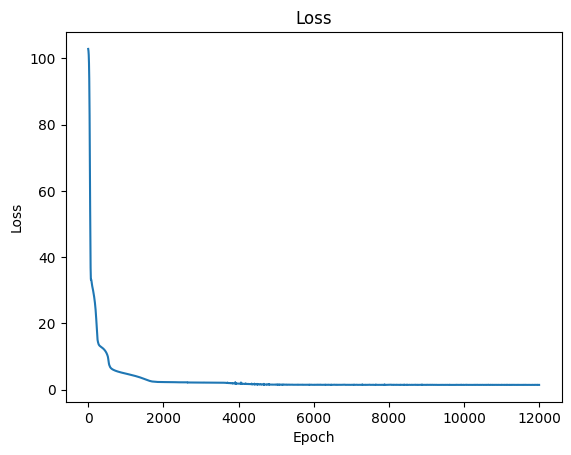

In [17]:
n_samples = 500
a = +0.5
b = +0.2
c = -4
x = np.linspace(-5, 5, n_samples)
y = a * x**2 + b * x + c
noise_scale = 1.0
y_noisy = y + noise_scale * np.random.randn(len(x))
data = np.vstack((x, y_noisy)).T
# Plot the toy dataset
# plt.scatter(data[:, 0], data[:, 1], s=10)
# plt.title("Toy Dataset with Negative 2nd-Degree Polynomial")
# plt.xlabel("X-axis")
# plt.ylabel("Y-axis")
# plt.show()

# Preprocess the data (standardize)
scaler = StandardScaler()
data = scaler.fit_transform(data)
# Convert data to PyTorch tensor
X_tensor = torch.FloatTensor(data)
X_tensor = X_tensor+10
X_tensor = X_tensor.to(device)

# Define the latent distribution (Gaussian)
latent_distribution = torch.distributions.MultivariateNormal(loc=torch.zeros(2).to(device), scale_tril=torch.eye(2).to(device))

# Create the flows
in_dim = 1 #X_tensor.shape[1] #since shape is (500,2), but after split we only have 1
#split_dim = in_dim // 2
out_dim = 1
num_params = 2
hidden_dim = 32
num_hidden = 2
coupling_layers = 4 # 4 eller 6 coupling

conditioner = Conditioner(in_dim=in_dim, out_dim=out_dim, num_hidden=num_hidden, hidden_dim=hidden_dim, num_params=num_params)
# def weights_init(m):
#      if isinstance(m, nn.Linear):
#          nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
# conditioner.apply(weights_init)  # Initialize weights
affine_coupling = AffineCouplingLayer(conditioner, split=lambda x: x.chunk(2, dim=-1)) # split the tensor into 2 parts
flows = [affine_coupling for _ in range(coupling_layers)]

# Create the Normalizing Flow model
flow_model = NormalizingFlow(latent_distribution, flows)
flow_model = flow_model.to(device)
#print("Flow_model device:", next(flow_model.parameters()).device)

lr = 0.0035
weight_decay = 1e-5  # L2 regularization strength to prevent overfitting

# Train the model
optimizer = torch.optim.Adam(flow_model.parameters(), lr=lr, weight_decay=weight_decay) 

losses = []
num_epochs = 12000  # flere epochs

for epoch in range(num_epochs):
    optimizer.zero_grad()
    log_prob = flow_model.log_prob(X_tensor)
    #log_prob = flow_model(X_tensor)
    loss = -torch.mean(log_prob) # negative log-likelihood
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    # Print losses per 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss:.4f}')
        
plt.plot(losses)
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# Generate samples from the trained model
with torch.no_grad():
    num_samples = 1000
    synthetic_data = flow_model.sample(num_samples=num_samples).cpu().numpy()

X_tensor = X_tensor.cpu().numpy()

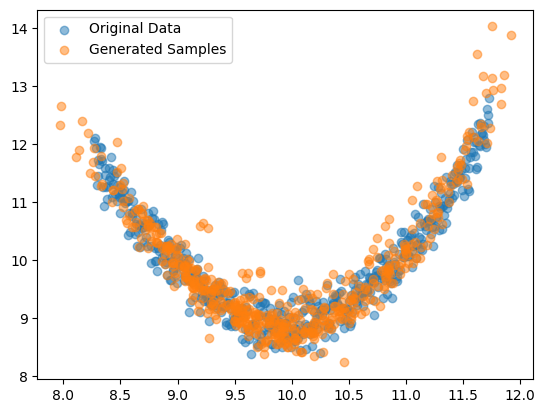

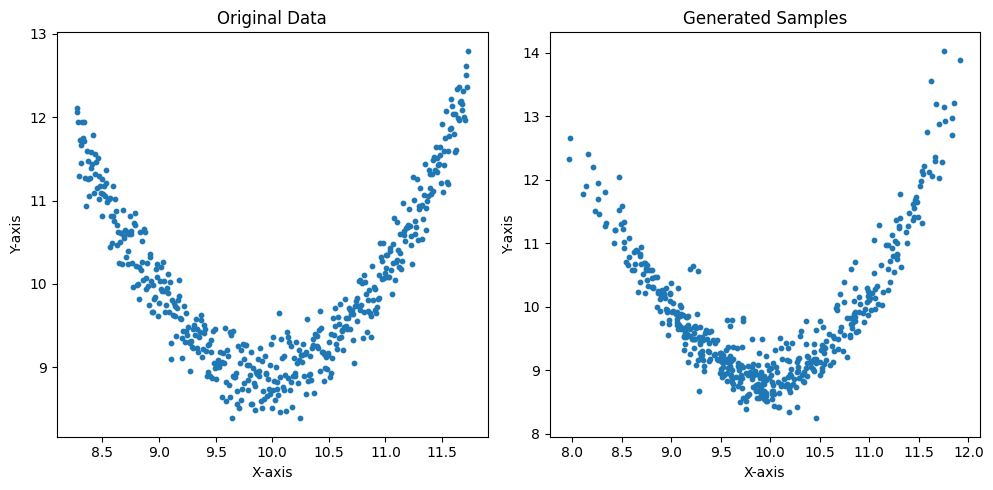

torch.Size([10000, 2])


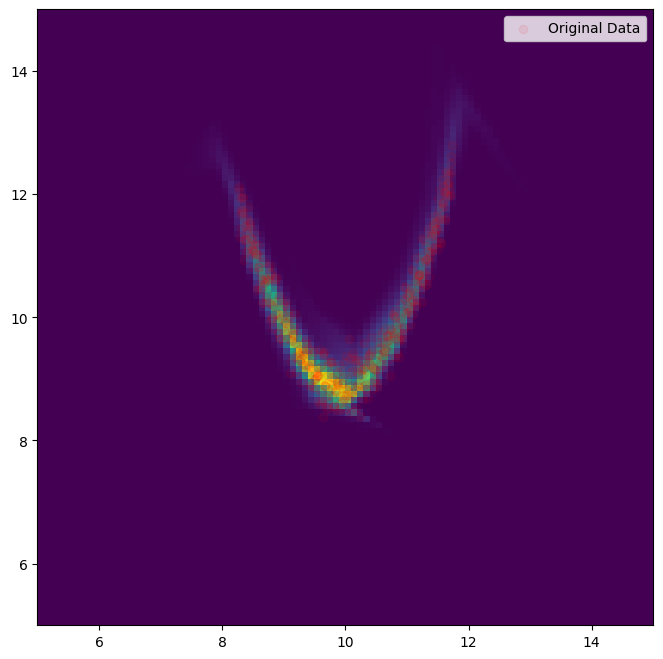

In [104]:
# Plot the original data and the generated samples on top of each other
plt.scatter(X_tensor[:, 0], X_tensor[:, 1], label='Original Data', alpha=0.5)
plt.scatter(synthetic_data[:, 0],synthetic_data[:, 1], label='Generated Samples', alpha=0.5)
plt.legend()
plt.show()

# Plot the original data and the generated samples in separate plots
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_tensor[:, 0], X_tensor[:, 1], s=10, label="Original Data")
plt.title("Original Data")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

plt.subplot(1, 2, 2)
plt.scatter(synthetic_data[:, 0], synthetic_data[:, 1], s=10, label="Generated Samples")
plt.title("Generated Samples")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

plt.tight_layout()
plt.show()

# Plot function f from network in a grid
# use mesh grid
nx, ny = (100, 100)
x = np.linspace(5, 15, nx)
y = np.linspace(5, 15, ny)
xv, yv = np.meshgrid(x, y)

con = np.stack((xv.flatten(), yv.flatten()),axis=1)
#print(con.shape)
X_tensor2 = torch.FloatTensor(con).to(device)
logprobs = flow_model.log_prob(X_tensor2)
logprobs = logprobs.cpu().reshape((100,100)).detach().numpy()
#make imshow size larger
plt.figure(figsize = (8,8))
plt.imshow(np.exp(logprobs), origin='lower', extent=[5,15,5,15])


#plot log_probs
# Plot the original data and the generated samples on top of each other

#plt.scatter(synthetic_data[:, 0],synthetic_data[:, 1], label='Generated Samples', alpha=0.05, color='yellow')
plt.scatter(X_tensor[:, 0], X_tensor[:, 1], label='Original Data', alpha=0.07, color='red')
plt.legend()

torch.Size([10000, 2])


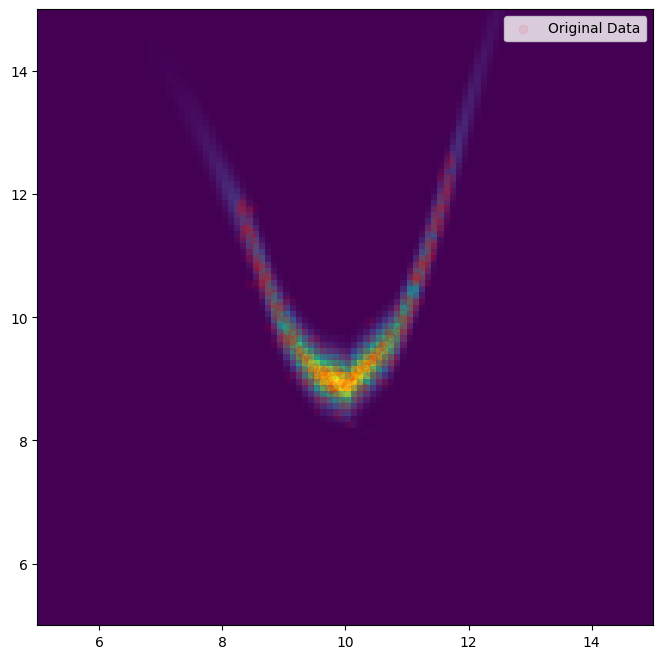

In [19]:
# Plot function f from network in a grid
# use mesh grid
nx, ny = (100, 100)
x = np.linspace(5, 15, nx)
y = np.linspace(5, 15, ny)
xv, yv = np.meshgrid(x, y)

con = np.stack((xv.flatten(), yv.flatten()),axis=1)
X_tensor2 = torch.FloatTensor(con).to(device)
logprobs = flow_model.log_prob(X_tensor2)
logprobs = logprobs.cpu().reshape((100,100)).detach().numpy()
plt.figure(figsize = (8,8))
plt.imshow(np.exp(logprobs), origin='lower', extent=[5,15,5,15])

#plt.scatter(synthetic_data[:, 0],synthetic_data[:, 1], label='Generated Samples', alpha=0.05, color='yellow')
plt.scatter(X_tensor[:, 0], X_tensor[:, 1], label='Original Data', alpha=0.07, color='red')
plt.legend()
plt.show()


Epoch [100/25000], Loss: 22.0717
Epoch [200/25000], Loss: 17.9539
Epoch [300/25000], Loss: 12.8426
Epoch [400/25000], Loss: 8.7573
Epoch [500/25000], Loss: 6.3128
Epoch [600/25000], Loss: 5.7095
Epoch [700/25000], Loss: 5.0096
Epoch [800/25000], Loss: 3.6389
Epoch [900/25000], Loss: 3.1394
Epoch [1000/25000], Loss: 3.1118
Epoch [1100/25000], Loss: 3.0807
Epoch [1200/25000], Loss: 3.0221
Epoch [1300/25000], Loss: 2.9688
Epoch [1400/25000], Loss: 2.8826
Epoch [1500/25000], Loss: 2.8180
Epoch [1600/25000], Loss: 2.7899
Epoch [1700/25000], Loss: 2.7696
Epoch [1800/25000], Loss: 2.7600
Epoch [1900/25000], Loss: 2.7527
Epoch [2000/25000], Loss: 2.7453
Epoch [2100/25000], Loss: 2.7381
Epoch [2200/25000], Loss: 2.7304
Epoch [2300/25000], Loss: 2.7223
Epoch [2400/25000], Loss: 2.6903
Epoch [2500/25000], Loss: 2.6347
Epoch [2600/25000], Loss: 2.5816
Epoch [2700/25000], Loss: 2.5312
Epoch [2800/25000], Loss: 2.4644
Epoch [2900/25000], Loss: 2.3283
Epoch [3000/25000], Loss: 2.1909
Epoch [3100/2500

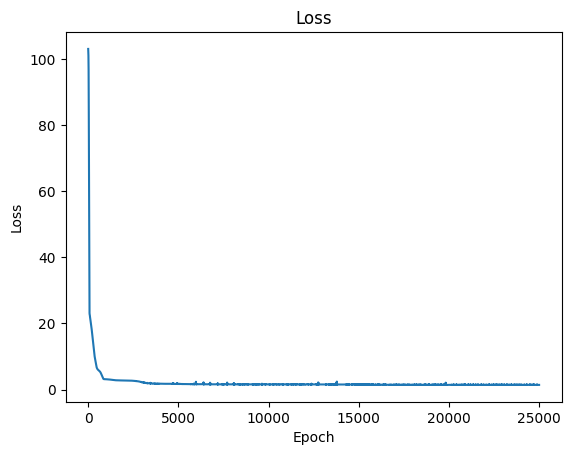

In [43]:
n_samples = 500
a = +0.5
b = +0.2
c = -4
x = np.linspace(-5, 5, n_samples)
y = a * x**2 + b * x + c
noise_scale = 1.0
y_noisy = y + noise_scale * np.random.randn(len(x))
data = np.vstack((x, y_noisy)).T
# Plot the toy dataset
# plt.scatter(data[:, 0], data[:, 1], s=10)
# plt.title("Toy Dataset with Negative 2nd-Degree Polynomial")
# plt.xlabel("X-axis")
# plt.ylabel("Y-axis")
# plt.show()

# Preprocess the data (standardize)
scaler = StandardScaler()
data = scaler.fit_transform(data)
# Convert data to PyTorch tensor
X_tensor = torch.FloatTensor(data)
X_tensor = X_tensor+10
X_tensor = X_tensor.to(device)

# Define the latent distribution (Gaussian)
latent_distribution = torch.distributions.MultivariateNormal(loc=torch.zeros(2).to(device), scale_tril=torch.eye(2).to(device))

# Create the flows
in_dim = 1 #X_tensor.shape[1] #since shape is (500,2), but after split we only have 1
#split_dim = in_dim // 2
out_dim = 1
num_params = 2
hidden_dim = 32
num_hidden = 2
coupling_layers = 4 # 4 eller 6 coupling

conditioner = Conditioner(in_dim=in_dim, out_dim=out_dim, num_hidden=num_hidden, hidden_dim=hidden_dim, num_params=num_params)
# def weights_init(m):
#      if isinstance(m, nn.Linear):
#          nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
# conditioner.apply(weights_init)  # Initialize weights
affine_coupling = AffineCouplingLayer(conditioner, split=lambda x: x.chunk(2, dim=-1)) # split the tensor into 2 parts
flows = [affine_coupling for _ in range(coupling_layers)]

# Create the Normalizing Flow model
flow_model = NormalizingFlow(latent_distribution, flows)
flow_model = flow_model.to(device)
#print("Flow_model device:", next(flow_model.parameters()).device)

lr = 0.003
weight_decay = 3e-6  # L2 regularization strength to prevent overfitting

# Train the model
optimizer = torch.optim.Adam(flow_model.parameters(), lr=lr, weight_decay=weight_decay) 

losses = []
num_epochs = 25000  # flere epochs

for epoch in range(num_epochs):
    optimizer.zero_grad()
    log_prob = flow_model.log_prob(X_tensor)
    #log_prob = flow_model(X_tensor)
    loss = -torch.mean(log_prob) # negative log-likelihood
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    # Print losses per 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss:.4f}')
        
plt.plot(losses)
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# Generate samples from the trained model
with torch.no_grad():
    num_samples = 1000
    synthetic_data = flow_model.sample(num_samples=num_samples).cpu().numpy()

X_tensor = X_tensor.cpu().numpy()

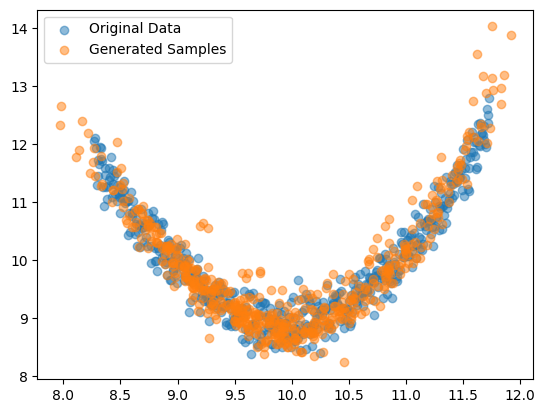

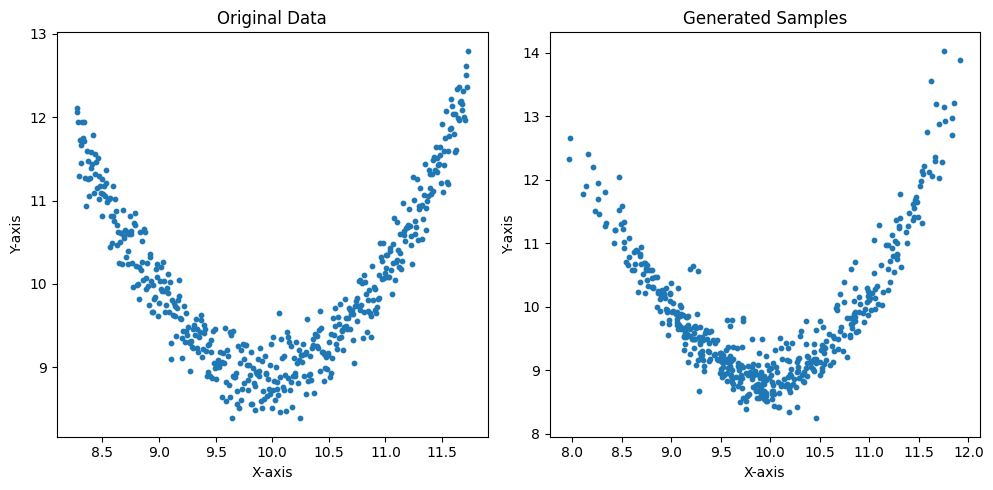

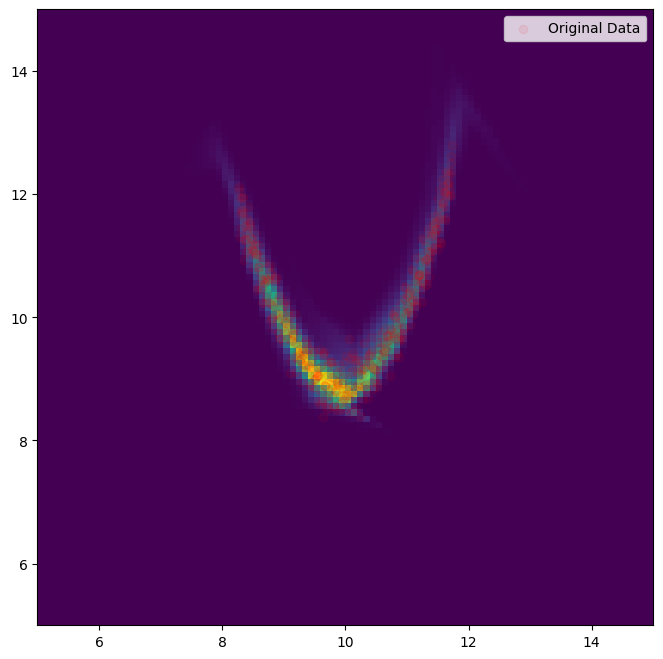

In [103]:
with torch.no_grad():
    num_samples = 500
    synthetic_data = flow_model.sample(num_samples=num_samples).cpu().numpy()
# Plot the original data and the generated samples on top of each other
plt.scatter(X_tensor[:, 0], X_tensor[:, 1], label='Original Data', alpha=0.5)
plt.scatter(synthetic_data[:, 0],synthetic_data[:, 1], label='Generated Samples', alpha=0.5)
plt.legend()
plt.show()

# Plot the original data and the generated samples in separate plots
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_tensor[:, 0], X_tensor[:, 1], s=10, label="Original Data")
plt.title("Original Data")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

plt.subplot(1, 2, 2)
plt.scatter(synthetic_data[:, 0], synthetic_data[:, 1], s=10, label="Generated Samples")
plt.title("Generated Samples")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

plt.tight_layout()
plt.show()

nx, ny = (100, 100)
x = np.linspace(5, 15, nx)
y = np.linspace(5, 15, ny)
xv, yv = np.meshgrid(x, y)

con = np.stack((xv.flatten(), yv.flatten()),axis=1)
X_tensor2 = torch.FloatTensor(con).to(device)
logprobs = flow_model.log_prob(X_tensor2)
logprobs = logprobs.cpu().reshape((100,100)).detach().numpy()
plt.figure(figsize = (8,8))
plt.imshow(np.exp(logprobs), origin='lower', extent=[5,15,5,15])

#plt.scatter(synthetic_data[:, 0],synthetic_data[:, 1], label='Generated Samples', alpha=0.05, color='yellow')
plt.scatter(X_tensor[:, 0], X_tensor[:, 1], label='Original Data', alpha=0.07, color='red')
plt.legend()
plt.show()


Epoch [100/12000], Loss: 31.6838
Epoch [200/12000], Loss: 23.9508
Epoch [300/12000], Loss: 13.6626
Epoch [400/12000], Loss: 12.8676
Epoch [500/12000], Loss: 11.7476
Epoch [600/12000], Loss: 8.6836
Epoch [700/12000], Loss: 6.0713
Epoch [800/12000], Loss: 5.4755
Epoch [900/12000], Loss: 4.7624
Epoch [1000/12000], Loss: 3.5132
Epoch [1100/12000], Loss: 2.9914
Epoch [1200/12000], Loss: 2.7762
Epoch [1300/12000], Loss: 2.6084
Epoch [1400/12000], Loss: 2.4944
Epoch [1500/12000], Loss: 2.4147
Epoch [1600/12000], Loss: 2.3593
Epoch [1700/12000], Loss: 2.3193
Epoch [1800/12000], Loss: 2.2689
Epoch [1900/12000], Loss: 2.2248
Epoch [2000/12000], Loss: 2.1874
Epoch [2100/12000], Loss: 2.1383
Epoch [2200/12000], Loss: 2.0960
Epoch [2300/12000], Loss: 2.0583
Epoch [2400/12000], Loss: 2.0221
Epoch [2500/12000], Loss: 1.9879
Epoch [2600/12000], Loss: 1.9553
Epoch [2700/12000], Loss: 1.9522
Epoch [2800/12000], Loss: 1.9929
Epoch [2900/12000], Loss: 1.8747
Epoch [3000/12000], Loss: 1.8546
Epoch [3100/12

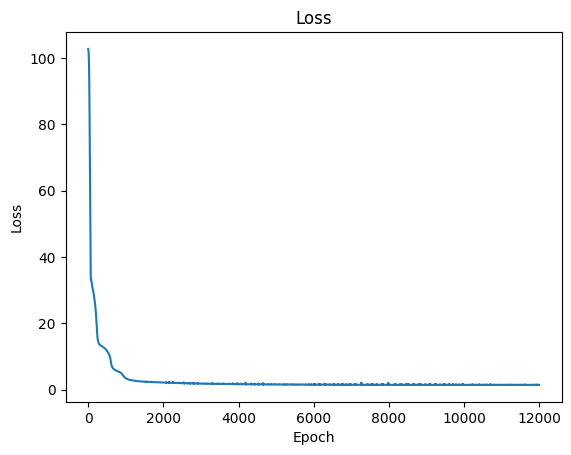

In [26]:
n_samples = 500
a = +0.5
b = +0.2
c = -4
x = np.linspace(-5, 5, n_samples)
y = a * x**2 + b * x + c
noise_scale = 1.0
y_noisy = y + noise_scale * np.random.randn(len(x))
data = np.vstack((x, y_noisy)).T
# Plot the toy dataset
# plt.scatter(data[:, 0], data[:, 1], s=10)
# plt.title("Toy Dataset with Negative 2nd-Degree Polynomial")
# plt.xlabel("X-axis")
# plt.ylabel("Y-axis")
# plt.show()

# Preprocess the data (standardize)
scaler = StandardScaler()
data = scaler.fit_transform(data)
# Convert data to PyTorch tensor
X_tensor = torch.FloatTensor(data)
X_tensor = X_tensor+10
X_tensor = X_tensor.to(device)

# Define the latent distribution (Gaussian)
latent_distribution = torch.distributions.MultivariateNormal(loc=torch.zeros(2).to(device), scale_tril=torch.eye(2).to(device))

# Create the flows
in_dim = 1 #X_tensor.shape[1] #since shape is (500,2), but after split we only have 1
#split_dim = in_dim // 2
out_dim = 1
num_params = 2
hidden_dim = 32
num_hidden = 2
coupling_layers = 2 # 4 eller 6 coupling

conditioner = Conditioner(in_dim=in_dim, out_dim=out_dim, num_hidden=num_hidden, hidden_dim=hidden_dim, num_params=num_params)
affine_coupling = AffineCouplingLayer(conditioner, split=lambda x: x.chunk(2, dim=-1)) # split the tensor into 2 parts
flows = [affine_coupling for _ in range(coupling_layers)]

# Create the Normalizing Flow model
flow_model = NormalizingFlow(latent_distribution, flows)
flow_model = flow_model.to(device)
#print("Flow_model device:", next(flow_model.parameters()).device)

# def weights_init(m):
#      if isinstance(m, nn.Linear):
#          nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
# flow_model.apply(weights_init)  # Initialize weights'

lr = 0.0035
weight_decay = 1e-5  # L2 regularization strength to prevent overfitting

# Train the model
optimizer = torch.optim.Adam(flow_model.parameters(), lr=lr, weight_decay=weight_decay) 

losses = []
num_epochs = 12000  # flere epochs

for epoch in range(num_epochs):
    optimizer.zero_grad()
    log_prob = flow_model.log_prob(X_tensor)
    #log_prob = flow_model(X_tensor)
    loss = -torch.mean(log_prob) # negative log-likelihood
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    # Print losses per 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss:.4f}')
        
plt.plot(losses)
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# Generate samples from the trained model
with torch.no_grad():
    num_samples = 1000
    synthetic_data = flow_model.sample(num_samples=num_samples).cpu().numpy()

X_tensor = X_tensor.cpu().numpy()

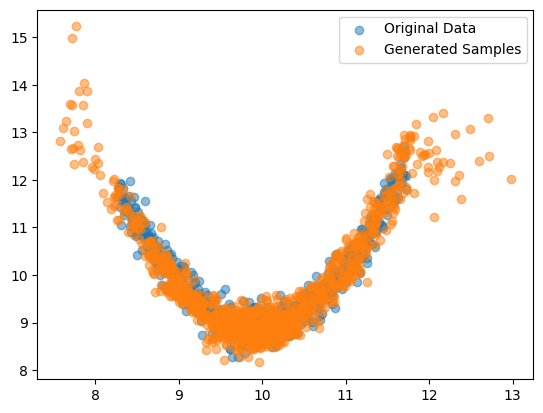

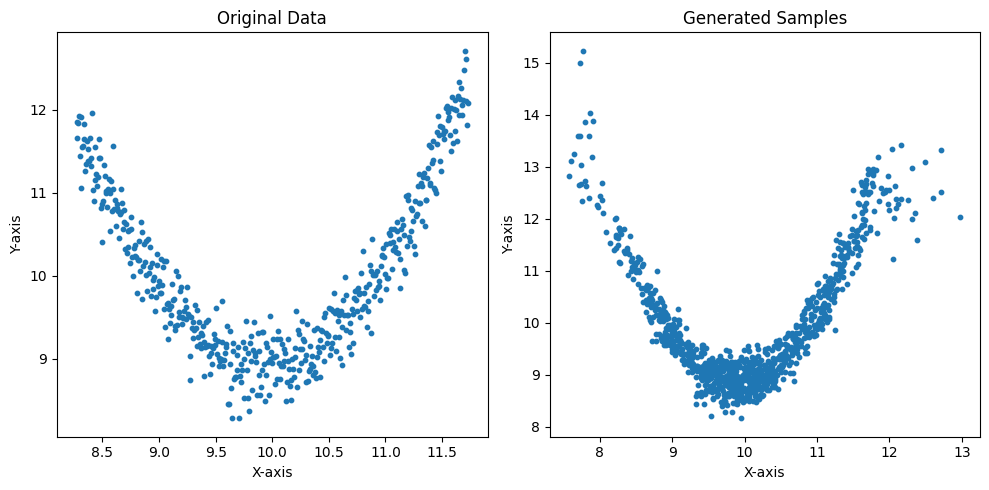

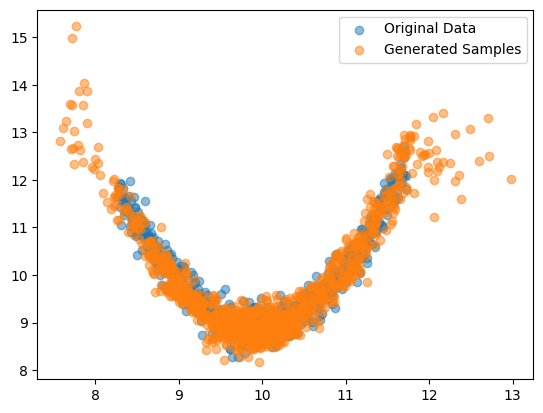

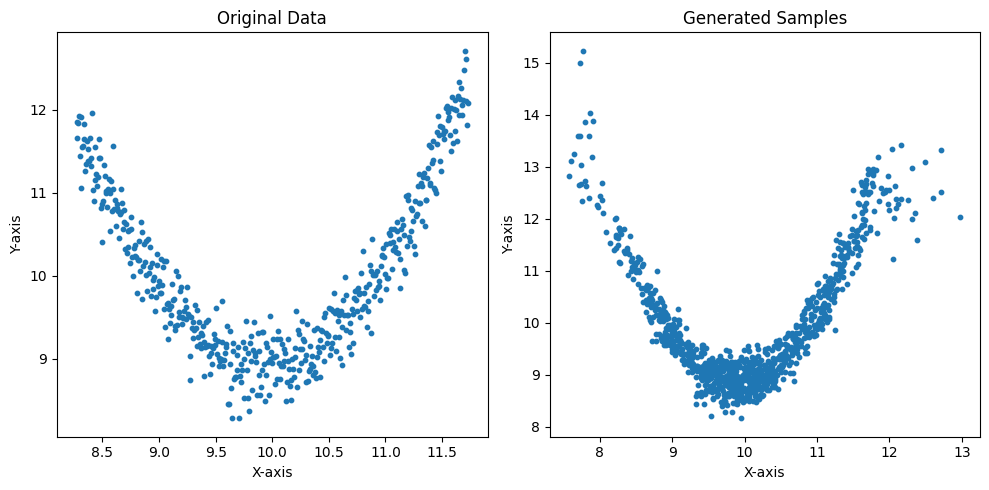

In [27]:
# Plot the original data and the generated samples on top of each other
plt.scatter(X_tensor[:, 0], X_tensor[:, 1], label='Original Data', alpha=0.5)
plt.scatter(synthetic_data[:, 0],synthetic_data[:, 1], label='Generated Samples', alpha=0.5)
plt.legend()
plt.show()

# Plot the original data and the generated samples in separate plots
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_tensor[:, 0], X_tensor[:, 1], s=10, label="Original Data")
plt.title("Original Data")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

plt.subplot(1, 2, 2)
plt.scatter(synthetic_data[:, 0], synthetic_data[:, 1], s=10, label="Generated Samples")
plt.title("Generated Samples")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

plt.tight_layout()
plt.show()

# Plot the original data and the generated samples on top of each other
plt.scatter(X_tensor[:, 0], X_tensor[:, 1], label='Original Data', alpha=0.5)
plt.scatter(synthetic_data[:, 0],synthetic_data[:, 1], label='Generated Samples', alpha=0.5)
plt.legend()
plt.show()

# Plot the original data and the generated samples in separate plots
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_tensor[:, 0], X_tensor[:, 1], s=10, label="Original Data")
plt.title("Original Data")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

plt.subplot(1, 2, 2)
plt.scatter(synthetic_data[:, 0], synthetic_data[:, 1], s=10, label="Generated Samples")
plt.title("Generated Samples")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

plt.tight_layout()
plt.show()

In [ ]:
# Convert synthetic_data to a PyTorch tensor
synthetic_data = torch.FloatTensor(synthetic_data)

# Track transformations through the model
transformed_samples = [synthetic_data]
for flow in flow_model.flows:
    synthetic_data = flow.f(synthetic_data)[0]  # Apply the forward transformation
    transformed_samples.append(synthetic_data)

# Convert the list of transformed samples to a numpy array
transformed_samples = torch.stack(transformed_samples).detach().numpy()

# Plot the transformation
plt.figure(figsize=(10, 5))
for i in range(num_samples):
    plt.plot(transformed_samples[:, i, 0], transformed_samples[:, i, 1], marker='o', markersize=1, alpha=0.5)

plt.title("Transformation through the Normalizing Flow")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.grid(True)
plt.show()

In [ ]:
# Define a function to visualize data transformation through the model
def visualize_transformation(model, data):
    # Convert data to tensor
    data = torch.FloatTensor(data)

    # Transform data through the model
    transformed_data, _ = model(data)

    return transformed_data.detach().numpy()

# Plot transformation through the model
transformed_data = visualize_transformation(flow_model, data)
plt.subplot(133)
plt.scatter(transformed_data[:, 0], transformed_data[:, 1], label='Transformed Data', alpha=0.5)
plt.title("Transformation through Model")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

plt.tight_layout()
plt.show()

In [ ]:
# Plot kernel density estimates for observations and generated samples
# Plot kernel density estimates for observations and generated samples
plt.figure(figsize=(10, 5))

# Plot kernel density estimate for observations
sns.kdeplot(data[:, 0], data[:, 1], cmap="Blues", shade=True, label="Observations", shade_lowest=False)

# Convert generated samples to a NumPy array
generated_samples = flow_model.sample(num_samples=num_samples).numpy()

# Plot kernel density estimate for generated samples
sns.kdeplot(generated_samples[:, 0], generated_samples[:, 1], cmap="Reds", shade=True, label="Generated Samples", shade_lowest=False)

plt.title("Kernel Density Estimates for Observations and Generated Samples")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.legend()
plt.grid(True)
plt.show()